In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import probit
import numpy as np

pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
plt.style.use('ggplot')

# Table of Contents

1. [Read Data](#Read-Data)
2. [Define Supporting Functions](#Define-Supporting-Functions)
3. [Cross-Sectional Regressions-Final screenshot](#Cross-Sectional-Regressions-Final-screenshot)
4. [Cross-Sectional Regression Table](#Cross-Sectional-Regression-Table)
5. [Growth regressions](#Growth-Regressions)
6. [Time Between Captures](#Time-Between-Captures)
7. [Y Dummy Variables](#Y-Dummy-Variables)


In [11]:
## Read Data
html = pd.read_csv('../data/07_28_merged_analysis.csv')

In [4]:
# Filter only clear successed and failures
html = html[html.failed.isin([0, 1])]

In [12]:
html.notes.value_counts()

good         739592
SmallBody     52421
JSHeavy       42209
emptyFile      2375
Name: notes, dtype: int64

**This line of code is very important:**

We're removing all HTML files that are either (1) empty, (2) not fully loaded in because of the JS error, or (3) have a suspiciously small contents inside of its `<body>`

The goal of this is to have less noise in our data, and to make the regressions run better

In [13]:
html = html[html.notes == 'good']

In [9]:
len(html.index)

213682

Still working with 213,000 HTML files for our training data, not bad...

#### Add y dummies:

Failed / succeeced *within* year [1-10] columns

In [ ]:
for i in range(1, 11):
    fColName = f"f_{i}"
    html[fColName] = ((html.lifespan <= i) & (html.Failed == 1)).astype('int')
    
for i in range(1, 11):
    sColName = f"s_{i}"
    html[sColName] = ((html.lifespan <= i) & (html.Failed == 0)).astype('int')

**The main dataset we'll using for regressions (for now):**

In [16]:
data = html.groupby('entityid').last()

---

## Define Supporting Functions

This function plots the regressions for us using seaborn and matplotlib.

Takes in an independent variable of interest (this will be plotted on the Y axis for better readbility), a control, and options to plot industry individually and or/save

Takes in optional fixed effects (maximum of one)

`y` and `data` are default arguments

TODO: Add option for multiple fixed effects

In [17]:
def plot_freg(y, data, control=None, industry=False, save=None):
    # Always do most basic OLS
    # sns.regplot(x='Failed', y=y, data=data, x_estimator=np.mean, color='g', label='Base OLS')
    
    if not industry:
        sns.regplot(x='Failed', y=y, data=data, x_estimator=np.mean, y_partial=control, \
                    color='b', label=f'Controlling for {control}');
        plt.legend()
    else:
        ind_groups = data.groupby('new_industrygroup')
        for name, group in ind_groups:
            # We're gonna ignore these industries for now
            ind_ignore = ["To Be Assigned", "Energy and Utilities", "Industrial Goods and Materials"]
            if name not in ind_ignore:
                sns.regplot(x='Failed', y=y, data=group, x_estimator=np.mean, y_partial=control, label=name);
        if control:
            plt.title(f'Predicting failure on {y} by industry, controlling for {control}')
        else:
            plt.title(f'Predicting failure on {y} by industry')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
    plt.xticks([0,1])
    if save:
        plt.savefig(save, dpi=200, bbox_inches='tight')

This function creates the regression model using the statsmodels library.

Y is assumed to be `failed`. Takes in any X variable, it just has to be inside `data`

Fixed effects for end year, industry, state, and start year.

`data`  and `x` are default arguments.

In [18]:
def run_model(x, data, y='failed', control=['end_yr', 'new_industrygroup', 'state', 'start_yr'], lifespanControl=None):
    
    if lifespanControl is not None:
        data.query('lifespan <= @lifespanControl')
    
    X = data[x]
    
    
    for i in control:
        i_dummies = pd.get_dummies(data[i], prefix=i, drop_first=True)
        X = pd.concat([X, i_dummies], axis=1)
    X = sm.add_constant(X)
    mod = sm.OLS(data[y], X).fit()
    return mod

## Cross-Sectional Regressions-Final screenshot

Our most basic regressions.

Unit of observation = Final snapshot for each company

### Includes Login

In [20]:
run_model('login_link', data).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 failed   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     361.5
Date:                Fri, 28 Jul 2023   Prob (F-statistic):               0.00
Time:                        21:31:55   Log-Likelihood:                -41436.
No. Observations:               61834   AIC:                         8.311e+04
Df Residuals:                   61717   BIC:                         8.416e+04
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               -0.0545      0.216     -0.252      0.801      -0.478       0.369
login_link                                          -0.0360      0.004     -8.404      0.000      -0.044      -0.028
end_yr_1998.0                                        0.0137      0.232      0.059      0.953      -0.441       0.469
end_yr_1999.0                                        0.0436      0.216      0.202      0.840      -0.379       0.466
end_yr_2000.0                                        0.0535      0.214      0.250      0.803      -0.366       0.473
end_yr_2001.0                                        0.3085      0.214      1.442      0.149      -0.111       0.728
end_yr_2002.0                                        0.6484      0.213      3.043      0.002       0.231       1.066
end_yr_2003.0                                        0.4010      0.213      1.879      0.060      -0.017       0.819
end_yr_2004.0                                        0.0848      0.213      0.397      0.691      -0.334       0.503
end_yr_2005.0                                        0.0229      0.214      0.107      0.915      -0.396       0.442
end_yr_2006.0                                       -0.0332      0.214     -0.156      0.876      -0.452       0.385
end_yr_2007.0                                       -0.0155      0.213     -0.073      0.942      -0.434       0.403
end_yr_2008.0                                       -0.0257      0.214     -0.120      0.904      -0.444       0.393
end_yr_2009.0                                       -0.0021      0.213     -0.010      0.992      -0.420       0.416
end_yr_2010.0                                       -0.0395      0.213     -0.185      0.853      -0.457       0.378
end_yr_2011.0                                       -0.0495      0.213     -0.232      0.817      -0.467       0.368
end_yr_2012.0                                       -0.0862      0.213     -0.404      0.686      -0.504       0.332
end_yr_2013.0                                       -0.1440      0.213     -0.675      0.499      -0.562       0.274
end_yr_2014.0                                       -0.1555      0.213     -0.730      0.466      -0.573       0.262
end_yr_2015.0                                       -0.2414      0.213     -1.133      0.257      -0.659       0.176
end_yr_2016.0                                       -0.3383      0.213     -1.588      0.112      -0.756       0.079
end_yr_2017.0                                       -0.3425      0.213     -1.608      0.108      -0.760       0.075
end_yr_2018.0                                       -0.3581      0.213     -1.681      0.093      -0.776       0.059
end_yr_2019.0                            

In [ ]:
sns.regplot(x='Failed', y='login', data=data, x_estimator=np.mean, color='b')
plt.ylabel('Has a login')
plt.ylim([0.1, 0.4])
plt.xticks([0, 1])

In [ ]:
plot_freg('login', data=data, control='start_yr', industry=True, save='login_industry.png')

In [ ]:
data[data.Failed == 0].login.mean()

### Webpage Size

Setup

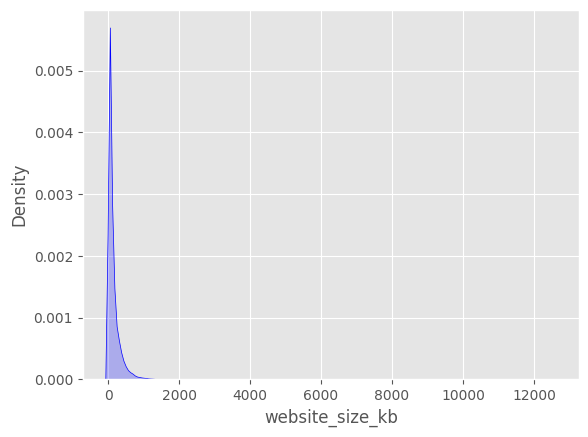

In [22]:
# Check out distribution
sns.kdeplot(data['website_size_kb'], color='b', fill='b');

**OLS Regression**

In [ ]:
run_model('websize_log').summary()

**Control for year**

In [ ]:
run_model('websize_log', control=['capture_yr']).rsquared

**Control for industry**

In [ ]:
run_model('websize_log', control=['new_industrygroup']).rsquared

**Plot, controlling for end year**

In [ ]:
plot_freg('careers', data, control='end_yr')

**Industry Plot**

In [ ]:
plot_freg('websize_log', data, industry=True)

**Plot for industry, controlling for capture year**

In [ ]:
plot_freg('websize_log', data, control='capture_yr', industry=True, save='websize_log_ind_ey.png')

## Cross-Sectional Regression Table

Create empty DataFrame

In [23]:
reg_results = pd.DataFrame(columns=['X', 'Y', 'Coefficient', 'Control', 'T', 'PValue', 'RSquared'])

In [24]:
data.columns

Index(['capture_yr', 'capture_m', 'file_path', 'file_exists',
       'website_size_kb', 'careers_link', 'blog_link', 'login_link',
       'contact_link', 'team_link', 'about_link', 'news_link', 'faq_link',
       'call_to_action_link', 'testimonial_link', 'careers_text', 'blog_text',
       'login_text', 'contact_text', 'team_text', 'about_text', 'news_text',
       'faq_text', 'call_to_action_text', 'testimonial_text', 'title',
       'description', 'keywords', 'p_count', 'h_count', 'img_count', 'a_count',
       'table_count', 'form_count', 'script_count', 'timestamp', 'notes',
       'entityname', 'new_industrygroup', 'state', 'weburl', 'pb_companyid',
       'startdate', 'lastVC', 'ownershipstatus', 'exit_date', 'failed',
       'end_yr', 'start_yr', 'lifespan'],
      dtype='object')

Define columns to run regressions on

In [26]:
cols_of_interest = [i for i in data.select_dtypes(include='number') if i not in ['failed']]

In [30]:
for i in cols_of_interest:
    print(i)
    mod = run_model(i, data)
    results = {
        'X': i,
        'Y': 'Failed',
        'Coefficient': mod.params[i],
        'Control': "",
        'T': mod.tvalues[i],
        'PValue': mod.pvalues[i],
        'RSquared': mod.rsquared,
    }
    reg_results = reg_results.append(results, ignore_index=True)
    # Control for end year, industry, state, and start year
    mod = run_model(i, data, control=['end_yr', 'new_industrygroup', 'state', 'start_yr'])
    results['Coefficient'] = mod.params[i]
    results['PValue'] =  mod.pvalues[i]
    results['RSquared'] = mod.rsquared
    results['Control'] = 'End Year, Industry, State, Year founded'
    reg_results = reg_results.append(results, ignore_index=True)

capture_yr
capture_m
file_exists
website_size_kb
careers_link
blog_link
login_link
contact_link
team_link
about_link
news_link
faq_link
call_to_action_link
testimonial_link
careers_text
blog_text
login_text
contact_text
team_text
about_text
news_text
faq_text
call_to_action_text
testimonial_text
title
description
keywords
p_count
h_count
img_count
a_count
table_count
form_count
script_count
timestamp
end_yr
start_yr
lifespan


Convert R-Squared out of scientific notation

In [34]:
reg_results['RSquared'] = reg_results['RSquared'].astype('float64')
reg_results['RSquared'] = np.round(reg_results['RSquared'], 4)

In [35]:
reg_results.name = 'Last screenshot cross-sectional regressions'

Sort by R-Squared

In [36]:
reg_results.sort_values('RSquared', ascending=False).reset_index(drop=True).head(15)

,X,Y,Coefficient,Control,T,PValue,RSquared
0,script_count,Failed,-0.001338,"End Year, Industry, State, Year founded",-14.600392,3.361050e-48,0.4060
1,script_count,Failed,-0.001338,,-14.600392,3.361050e-48,0.4060
2,capture_yr,Failed,-0.008790,,-13.576058,6.380591e-42,0.4057
3,img_count,Failed,-0.000594,"End Year, Industry, State, Year founded",-13.848375,1.512148e-43,0.4057
4,img_count,Failed,-0.000594,,-13.848375,1.512148e-43,0.4057
5,capture_yr,Failed,-0.008790,"End Year, Industry, State, Year founded",-13.576058,6.380591e-42,0.4057
6,website_size_kb,Failed,-0.000104,,-12.709596,5.820046e-37,0.4055
7,website_size_kb,Failed,-0.000104,"End Year, Industry, State, Year founded",-12.709596,5.820046e-37,0.4055
8,about_link,Failed,-0.054165,,-12.336921,6.301124e-35,0.4054
9,about_text,Failed,-0.054165,"End Year, Industry, State, Year founded",-12.336921,6.301124e-35,0.4054


## Growth Regressions

**Setup**

Add these growth columns for every column that we care about

In [37]:
g_cols_of_interest = ['website_size_kb', 'careers', 'blog', 'login', 'contact',
       'team', 'about', 'news', 'faq', 'call_to_action', 'testimonial',
       'title', 'description', 'keywords', 'p_count', 'h_count', 'img_count',
       'a_count', 'table_count', 'form_count', 'script_count']
binCols =  ['careers', 'blog', 'login', 'contact',
       'team', 'about', 'news', 'faq', 'call_to_action', 'testimonial',
       'title', 'description', 'keywords']

Calculate Percentage Difference

In [38]:
def find_last_diff(x, col, start, end, isBin):
    if len(x.index) > end:
        start_val = x.iloc[start][col]
        end_val = x.iloc[end][col]
        diff = end_val - start_val
        if isBin and diff == 1:
            diff = 100
        if start_val == 0:
            diff = (((end_val + 1) - (start_val + 1)) / (start_val + 1)) * 100
        else:
            diff = ((end_val - start_val) / start_val) * 100
        return diff
    return None

Add the column to the HTML DataFrame

In [39]:
def add_last_growth_col(col, colName, start, end):
    s = html.groupby('entityid').apply(lambda x: find_last_diff(x, col, start, end, isBin=(col in binCols)))
    s.name = colName
    return html.merge(s, on='entityid')

Add ALL of the columns to the HTML DataFrame

In [40]:
def create_growth_cols(start, end):
    global html
    for i in g_cols_of_interest:
        colName = f"g{start}{end}_{i}"
        html = add_last_growth_col(col=i, colName=colName, start=0, end=3)

Run regressions on the growth columns and return a table containing all the important info about the regressions

In [41]:
def growth_reg(start, end, lifespanControl=None):
    growth_reg_results = pd.DataFrame(columns=['X', 'Y', 'Coefficient', 'Control', 'T', 'PValue', 'RSquared'])    

    for i in g_cols_of_interest:
        i = f"g{start}{end}_{i}"
        
        # Control for end year, industry, state, and start year
        mod = run_model(i, control=['end_yr', 'new_industrygroup', 'state', 'start_yr'], lifespanControl=lifespanControl)
        
        results = {
            'X': i,
            'Y': 'Failed',
            'Coefficient': mod.params[i],
            'Control': 'End Year, Industry, State, Year founded',
            'T': mod.tvalues[i],
            'PValue': mod.pvalues[i],
            'RSquared': mod.rsquared
        }
        
        growth_reg_results = growth_reg_results.append(results, ignore_index=True)
        

    # Convert Rsquared to float
    growth_reg_results['RSquared'] = growth_reg_results['RSquared'].astype('float64')
    growth_reg_results['RSquared'] = np.round(growth_reg_results['RSquared'], 4)
    
    # Set name
    growth_reg_results.set_camption = f"% Growth from years {start} to {end}"
    
    return growth_reg_results

Combine the functions above, return a DF that acts as a table for ..


TODO: Understand this function more lol

In [42]:
def master_reg(data, start, end, lifespanControl):
    colPrefix = f"g{start}{end}_"
    
    # See if columns exist
    columnsExist = set([colPrefix + i for i in g_cols_of_interest]).issubset(html.columns)

    if not columnsExist:
        # Create columns (takes ~2 minutes)
        create_growth_cols(start, end)

    # Redefine regression dataset with new growth columns
    data = html.groupby('entityid').last()
    colPrefix = f"g{start}{end}_"

    # Drop any rows with NA values for any of the columns we're running regressions on
    data = data.dropna(subset=[colPrefix + i for i in g_cols_of_interest]) # Remove NA

    # Create regression DF
    gr_results = growth_reg(start, end, lifespanControl=lifespanControl)

    # Styling
    if lifespanControl is not None:
        captionTxt = f"Exited within {lifespanControl} years, Growth from snapshot {start}-{end}"
    else:
        captionTxt = f"Growth from snapshot {start}-{end}"
    return gr_results

Setup

In [43]:
start = 1
end = 3
lifespanControl = 5

Control:
    Every company that lasted 3 years the same amount of time for the outcome variable to be 1
    

In [45]:
master_reg(data=data, start=start, end=end, lifespanControl=lifespanControl)

KeyboardInterrupt: 

---

## Time Between Captures

The distance in time between captures may be indicative of many things about the website...

1. How much traffic is the website getting?
    - Hypothesis: websites with less web traffic are less likely to be crawled.
2. How much is the website actually changing?
    - Hypothesis: websites with minimal changes to their website will not get crawled.
    
If both hypotheses are true, the less snapshots a website has, the more likely it is a website that is unchanging and not receiving much web traffic.
- Does this sound like a good signal for failure? In some industries, certainly. In an industry like healthcare, less so.

What's the most robust way of measuring this? Getting a list of **all** the snapshots we have for each company. With some time constraints of-course (-2 years before start date, +5 years after exit_date/lastVC).
- Essentially, we'd just have a list of timestamps per company. Let's make a script for that...

### Read data

In [ ]:
pd.read_csv('../data/simple_jsons')

Time between snapshots may be a signal that we can free-ride

Create empty DataFrame

In [ ]:
reg_results = pd.DataFrame(columns=['X', 'Y', 'Coefficient', 'Control', 'T', 'PValue', 'RSquared'])

Define columns to run regressions on

In [ ]:
cols_of_interest = [i for i in data.select_dtypes(include='number') if i not in ['Failed']]

In [ ]:
data['a_log'].describe()

In [ ]:
for i in cols_of_interest:
    print(i)
    mod = run_model(i)
    results = {
        'X': i,
        'Y': 'Failed',
        'Coefficient': mod.params[i],
        'Control': "",
        'T': mod.tvalues[i],
        'PValue': mod.pvalues[i],
        'RSquared': mod.rsquared,
    }
    reg_results = reg_results.append(results, ignore_index=True)
    # Control for end year, industry, state, and start year
    mod = run_model(i, control=['end_yr', 'new_industrygroup', 'state', 'start_yr'])
    results['Coefficient'] = mod.params[i]
    results['PValue'] =  mod.pvalues[i]
    results['RSquared'] = mod.rsquared
    results['Control'] = 'End Year, Industry, State, Year founded'
    reg_results = reg_results.append(results, ignore_index=True)

Convert R-Squared out of scientific notation

In [ ]:
reg_results['RSquared'] = reg_results['RSquared'].astype('float64')
reg_results['RSquared'] = np.round(reg_results['RSquared'], 4)

In [ ]:
reg_results.name = 'Last screenshot cross-sectional regressions'

Sort by R-Squared

In [ ]:
reg_results.sort_values('RSquared', ascending=False).reset_index(drop=True).head(15)

**Setup**

In [ ]:
html = html.sort_values(['entityid', 'capture_yr', 'capture_m'])

In [ ]:
def find_time_diff(x, start, end):
    if len(x.index) > max(abs(start), abs(end)):
        start_yr = x.iloc[start]['capture_yr'] * 12 # Convert to months
        start_m = x.iloc[start]['capture_m']
        start_total = start_yr + start_m
        
        end_yr = x.iloc[end]['capture_yr'] * 12 # Convert to months
        end_m = x.iloc[end]['capture_m']
        end_total = end_yr + end_m

        total_m_diff = end_total - start_total
        
        return total_m_diff
    else:
        return None
        

**What's the difference in time between the first capture and the second capture?**

Create column

In [ ]:
def add_td_col(start, end):
    new_td = html.groupby('entityid').apply(lambda x: find_time_diff(x, start, end))
    new_td.name = f"td_{start}{end}"
    return html.merge(new_td, left_on='entityid', right_index=True)

In [ ]:
html = add_td_col(4, 5)

**What's the difference in time betweent the last capture and the second-to-last capture?**

Create column

In [ ]:
td_last2 = html.groupby('entityid').apply(lambda x: find_time_diff(x, -2, -1))

In [ ]:
td_last2.name = 'td_last2'
html = html.merge(td_last2, left_on='entityid', right_index=True)

**What's the average difference in time (months) between each capture?**

Create column. Calculating standard deviation could work here

In [ ]:
html['total_capture_m'] = html['capture_yr'] * 12 + html['capture_m']
td_stdev = html.groupby('entityid')['total_capture_m'].std()

In [ ]:
td_stdev.name = 'td_stdev'
html = html.merge(td_stdev, left_on='entityid', right_index=True)

What's the difference in time between the second and third capture?

In [ ]:
td_12 = html.groupby('entityid').apply(lambda x: find_time_diff(x, 1, 3))

In [ ]:
td_12.name = 'td_12'
html = html.merge(td_12, left_on='entityid', right_index=True)

In [ ]:
data.td_12.describe()

**Run regressions**

In [ ]:
cols = ['td_01', 'td_12', 'td_last2', 'td_stdev']

In [ ]:
data = html.groupby('entityid').first()
data = data.dropna(subset=cols) # Remove NA

Create empty DataFrame

In [ ]:
reg_results = pd.DataFrame(columns=['X', 'Y', 'Coefficient', 'Control', 'T', 'PValue', 'RSquared'])

In [ ]:
for c in cols:
    mod = run_model(c, control=['end_yr', 'new_industrygroup', 'state', 'start_yr'])
    results = {
        'X': c,
        'Y': 'Failed',
        'Coefficient': mod.params[c],
        'Control': 'End year, industry, state, start year',
        'T': mod.tvalues[c],
        'PValue': mod.pvalues[c],
        'RSquared': mod.rsquared,
    }
    reg_results = reg_results.append(results, ignore_index=True)


In [ ]:
reg_results

## Number of Captures downloaded

In [ ]:
# TODO: Fix the _x thing

In [ ]:
html.groupby('entityid').file_exists.sum()

In [ ]:
data = html.groupby('entityid').first()

In [ ]:
run_model('num_captures', control=['end_yr', 'new_industrygroup', 'state', 'start_yr']).summary()

In [ ]:
html = html.merge(td_last2, left_on='entityid', right_index=True)

---

## Y Dummy Variables

This is sort-of like a hazard model

The columns were added in the setup section [here](#Add-y-dummies:)

First, let's look at a density plot of the Failed companies, comparing their last VC time and their start date

In [ ]:
sns.kdeplot(pd.to_datetime(data.query('Failed == 1').lastVC) \
    .dt.year, \
    color='b', fill='b', label='last vc (year)');
sns.kdeplot(data.query('Failed == 1').start_yr, color='r', fill='b', label='start date(year)');
plt.xlabel('Year')
plt.legend();

In [ ]:
data.loc[data['Failed'] == 1, 'lifespan'].describe()

**First example:** What predicts whether a company will be failed within in 5 years?

*Caveat: many of these predictors require a company to exist for some minimum amount of time (e.g. if we're looking at the third screnshot as a predictor, the company must have been around for at least a year...)*

**1.1:** Number of images in the third screenshot

*For every additional `<img>` tag, a websites probaility that it has failed or succeeded within `[1-10]` years goes up or decreases by some amount...*

In [ ]:
Define the 

In [ ]:
data = html.groupby('entityid').nth(3) # Create new dataset

In [ ]:
control=['new_industrygroup', 'state'] # Controls

Define independent variable and covariates:

In [ ]:
sns.kdeplot(np.log(data['img_count']).replace([-np.inf], 0), color='b', fill='b');
plt.xlabel('lm(img_count)')

In [ ]:
def f_within_reg(data, colName, y, log=False, control=['new_industrygroup', 'state', 'start_yr']):
    # Define ind. var.    
    if log:
        X = np.log(data[colName]).replace([-np.inf], 0);
    else:
        X = data[colName]
        
    # Define covariates
    for i in control:
        i_dummies = pd.get_dummies(data[i], prefix=i, drop_first=True)
    X = sm.add_constant(X)
    
    # Run regression
    mod = sm.OLS(data[y], X).fit()
    return mod

---

In [ ]:
f_within_results = pd.DataFrame(columns=['X', 'Y', 'Coefficient', 'P-Value', 'T-Value', 'R-Squared', 'Note'])

What are we predicting at this time? Failed within 5 years, so:

In [ ]:
y_col = 'f_5'
y_yr = 5

Now, we want to exclude any companies that didn't have enough time to fail/survive within {y_yr} years...

**Note:** This should only matter for companies we are *testing* (i.e. we don't know the outcome of already...) because for exited / failed companies, they've basically been given enough time, as shown by their outcome?

Let's just look at a kdeplot of the start years for these companies

In [ ]:
sns.kdeplot(data.query('Failed == 1').start_yr, color='r', fill='b', label='Failed');
sns.kdeplot(data.query('Failed == 0').start_yr, color='b', fill='b', label='Exited');
plt.ylim([0, 0.1]);
plt.legend();

List the columns we want to get data for...

**Set 1: Binaries**

In [ ]:
fg_cols = [
        "careers",
        "blog",
        "login",
        "contact",
        "team",
        "about",
        "news",
        "faq",
        "call_to_action",
        "testimonial",
        "title",
        "description",
        "keywords"
    ]

In [ ]:
for i in fg_cols:
    mod = f_within_reg(data, i, y_col)
    ratio_val = np.round(data[i].mean(), 3)
    ratio = f"{ratio_val} of firms in the data have {i}"
    f_within_results.loc[len(f_within_results.index)] = \
        ["Pr(" + i + ") at 3rd screenshot", f'Failed within {y_yr} years', \
         mod.params[i], mod.pvalues[i], mod.tvalues[i], mod.rsquared, ratio]
    
    

In [ ]:
f_within_results

**Set 2: Tag counts (log)**

In [ ]:
log_cols = ["p_count",
"h_count",
"img_count",
"a_count",
"table_count",
"form_count",
"script_count"]

In [ ]:
for i in log_cols:
    mod = f_within_reg(data, i, y_col, log=True);
    f_within_results.loc[len(f_within_results.index)] = \
        ["lm(" + i + ") at 3rd screenshot", f'Failed within {y_yr} years', \
         mod.params[i], mod.pvalues[i], mod.tvalues[i], mod.rsquared, ""]
    
    

In [ ]:
f_within_results.sample(10)

**Set 3: Growth**

**Create % growth columns between snapshots 2-3 and 3-4 (these functions both take minutes each time)**

In [ ]:
create_growth_cols(2, 3)
create_growth_cols(3, 4)

In [ ]:
html.columns

In [ ]:
data = html.groupby('entityid').last()

In [ ]:
for i in data.columns:
    print('"' + i + '",')

In [ ]:
g_cols = [
"g23_website_size_kb",
"g23_careers",
"g23_blog",
"g23_login",
"g23_contact",
"g23_team",
"g23_about",
"g23_news",
"g23_faq",
"g23_call_to_action",
"g23_testimonial",
"g23_title",
"g23_description",
"g23_keywords",
"g23_p_count",
"g23_h_count",
"g23_img_count",
"g23_a_count",
"g23_table_count",
"g23_form_count",
"g23_script_count",
"g34_website_size_kb",
"g34_careers",
"g34_blog",
"g34_login",
"g34_contact",
"g34_team",
"g34_about",
"g34_news",
"g34_faq",
"g34_call_to_action",
"g34_testimonial",
"g34_title",
"g34_description",
"g34_keywords",
"g34_p_count",
"g34_h_count",
"g34_img_count",
"g34_a_count",
"g34_table_count",
"g34_form_count",
"g34_script_count"]

In [ ]:
data = data.dropna(subset=g_cols, axis=0)

In [ ]:
data

In [ ]:
for i in g_cols:
    mod = f_within_reg(data, i, y_col)
    f_within_results.loc[len(f_within_results.index)] = \
        [i + " at 3rd screenshot", f'Failed within {y_yr} years', \
         mod.params[i], mod.pvalues[i], mod.tvalues[i], mod.rsquared, ""]


In [ ]:
f_within_results.tail(10)